<a href="https://colab.research.google.com/github/tostaylo/object-detection-to-speech/blob/main/Object_Detection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# YOLOv5 dependencies
import torch
!pip install GitPython
import IPython

# common
from PIL import Image as pil_Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# helpers

def get_img_from_temp_directory(img):
  # workaround function for being able to convert images to format needed by prediction models
  image_directory = 'temp_images'
  image_path = f'{image_directory}/image.jpg'
  isDirectory = os.path.exists(image_directory)
  
  if (not isDirectory):
    os.mkdir(image_directory)

  img.save(image_path)
  im = cv2.imread(image_path)

  return im

In [3]:
# Necessary to get names for Detectron2 predictions
categories = {
 0: u'__background__',
 1: u'person',
 2: u'bicycle',
 3: u'car',
 4: u'motorcycle',
 5: u'airplane',
 6: u'bus',
 7: u'train',
 8: u'truck',
 9: u'boat',
 10: u'traffic light',
 11: u'fire hydrant',
 12: u'stop sign',
 13: u'parking meter',
 14: u'bench',
 15: u'bird',
 16: u'cat',
 17: u'dog',
 18: u'horse',
 19: u'sheep',
 20: u'cow',
 21: u'elephant',
 22: u'bear',
 23: u'zebra',
 24: u'giraffe',
 25: u'backpack',
 26: u'umbrella',
 27: u'handbag',
 28: u'tie',
 29: u'suitcase',
 30: u'frisbee',
 31: u'skis',
 32: u'snowboard',
 33: u'sports ball',
 34: u'kite',
 35: u'baseball bat',
 36: u'baseball glove',
 37: u'skateboard',
 38: u'surfboard',
 39: u'tennis racket',
 40: u'bottle',
 41: u'wine glass',
 42: u'cup',
 43: u'fork',
 44: u'knife',
 45: u'spoon',
 46: u'bowl',
 47: u'banana',
 48: u'apple',
 49: u'sandwich',
 50: u'orange',
 51: u'broccoli',
 52: u'carrot',
 53: u'hot dog',
 54: u'pizza',
 55: u'donut',
 56: u'cake',
 57: u'chair',
 58: u'couch',
 59: u'potted plant',
 60: u'bed',
 61: u'dining table',
 62: u'toilet',
 63: u'tv',
 64: u'laptop',
 65: u'mouse',
 66: u'remote',
 67: u'keyboard',
 68: u'cell phone',
 69: u'microwave',
 70: u'oven',
 71: u'toaster',
 72: u'sink',
 73: u'refrigerator',
 74: u'book',
 75: u'clock',
 76: u'vase',
 77: u'scissors',
 78: u'teddy bear',
 79: u'hair drier',
 80: u'toothbrush'
}

In [4]:

def get_yolo_model():
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
  model = model.eval()

  return model

def yolo_accuracy(img, model):
  model_output = model([img])

  df_json = model_output.pandas().xyxy[0].to_json(orient="records") 

  if(len(df_json) == 0 ):
    return 0;

  prediction_data = json.loads(df_json)

  if(len(prediction_data) == 0):
    return 0;

  first_prediction = prediction_data[0]
 
  confidence = first_prediction['confidence']
  name = first_prediction['name']

  confidence_to_percent = round(confidence * 100, 2)
  
  print('hi from yolo', confidence_to_percent, name)

  return confidence_to_percent

In [5]:
# Code reference:
# Detectron2 Beginner's Tutorial
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=FsePPpwZSmqt

In [6]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ljxfo0ld
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ljxfo0ld


In [7]:
# Detectron 2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import io, os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [8]:

def get_detectron_predictor():
  cfg = get_cfg()

  cfg.MODEL.DEVICE = 'cpu'
  # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
  # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
  predictor = DefaultPredictor(cfg)

  return predictor




In [9]:
def detectron_accuracy(img, predictor):
  outputs = predictor(img)
  
  instances = outputs['instances']
  scores = instances.scores.cpu().tolist()
  prediction_classes = instances.pred_classes.cpu().tolist()
   
  if(len(scores) == 0):
    return 0


  predicted_categories = list(map(lambda category_id: categories[category_id + 1], prediction_classes  ))
  
  first_prediction = predicted_categories[0]
  first_score = scores[0]
  first_score_to_percent = round(first_score * 100, 2) 

  print('hi from detectron', first_score_to_percent, first_prediction)

  return first_score_to_percent

# Cifar-10 Image Dataset

Attempting to use Cifar-10 dataset for image classification

In [10]:
# Import cifar-10 img dataset
from keras.datasets import cifar10
import matplotlib.pyplot as plt

# load dataset
# each row is one img
(trainX, trainY), (testX, testY) = cifar10.load_data()

From the Cifar-10 documentation:

- data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
- labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

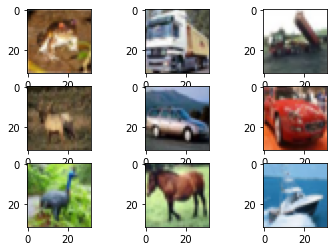

In [11]:
# show some example images
for i in range(9):
	plt.subplot(330 + 1 + i)  # define subplot
	plt.imshow(trainX[i])     # plot raw pixel data
plt.show()                  # show the figure

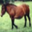

In [12]:
# Reading in pixels with pil_Image as RGB format (what we want)
pil_img = pil_Image.fromarray(trainX[7])
pil_img

In [13]:
# When cv2 reads the pixels, it asssume BGR, hence the image output
success, encoded_image = cv2.imencode('.png', trainX[7]) # img as np array
image_as_bytes = encoded_image.tobytes()                 # img as bytes

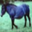

In [14]:
# Can use either encoded_image or image_as_bytes
img = pil_Image.open(io.BytesIO(encoded_image))
img

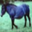

In [15]:
img = pil_Image.open(io.BytesIO(image_as_bytes))
img

# Attempting to use more high-res dataset (caltech101)

In [16]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [17]:
ds, info = tfds.load('caltech101', split='train', with_info=True)

caltech101_df = tfds.as_dataframe(ds.take(4), info)

,image,image/file_name,label
0,,image_0009.jpg,51 (inline_skate)
1,,image_0031.jpg,7 (beaver)
2,,image_0029.jpg,79 (saxophone)
3,,image_0002.jpg,61 (mandolin)

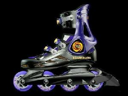
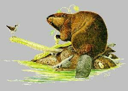
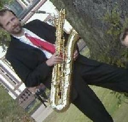
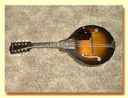

In [18]:
caltech101_df

In [19]:
yolo_model = get_yolo_model()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: YOLOv5 requirement "PyYAML>=5.3.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-11-25 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [20]:
# Predicting these 4 images with YOLOv5
for img in caltech101_df['image']:
  pil_image = pil_Image.fromarray(img)
  yolo_accuracy(pil_image, yolo_model)

hi from yolo 35.36 person


YOLO was able to make a prediction on 1 of the 4 images (img #3).

In [21]:
detectron_predictor = get_detectron_predictor()

In [22]:
# Trying to predict the same images with Detectron2
for img in caltech101_df['image']:
  pil_image = pil_Image.fromarray(img)
  im = get_img_from_temp_directory(pil_image)

  detectron_accuracy(im, detectron_predictor)

hi from detectron 83.43 motorcycle
hi from detectron 89.54 bird
hi from detectron 94.5 person


In [23]:
# Passing in the image in different format produces different results. Why?
for img in caltech101_df['image']:
  detectron_accuracy(img, detectron_predictor)

hi from detectron 79.66 motorcycle
hi from detectron 81.77 teddy bear
hi from detectron 50.76 person
hi from detectron 55.45 car


Detectron, while taking longer, was able to predict 3/4 images.

In [24]:
# Code Reference for webcam functionality:
# From: Google Colab "Camera Capture" snippet

In [25]:
# from IPython.display import display, Javascript, Audio
# from google.colab.output import eval_js
# from base64 import b64decode

# !pip install gTTS
# from gtts import gTTS

# def take_photo(filename='photo.jpg', quality=0.8):
#   js = Javascript('''
#     async function takePhoto(quality) {
#       const div = document.createElement('div');
#       const capture = document.createElement('button');
#       capture.textContent = 'Capture';
#       div.appendChild(capture);

#       const video = document.createElement('video');
#       video.style.display = 'block';
#       const stream = await navigator.mediaDevices.getUserMedia({video: true});

#       document.body.appendChild(div);
#       div.appendChild(video);
#       video.srcObject = stream;
#       await video.play();

#       // Resize the output to fit the video element.
#       google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

#       // Wait for Capture to be clicked.
#       await new Promise((resolve) => capture.onclick = resolve);

#       const canvas = document.createElement('canvas');
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       canvas.getContext('2d').drawImage(video, 0, 0);
#       stream.getVideoTracks()[0].stop();
#       div.remove();
#       return canvas.toDataURL('image/jpeg', quality);
#     }
#     ''')
#   display(js)
#   data = eval_js('takePhoto({})'.format(quality))
#   binary = b64decode(data.split(',')[1])

#   #call whichever model you wish
#   yolo_prediction = yolo_accuracy(binary)
#   print(f'Yolov5 prediction: {yolo_prediction}')


#   #output prediction to audio

#   tts = gTTS(yolo_prediction)
#   tts.save('prediction_audio.wav')
#   prediction_audio = 'prediction_audio.wav'
#   display(Audio(prediction_audio, autoplay=True)) 


#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return filename

In [26]:
# from IPython.display import Image
# try:
#   filename = take_photo()
#   print('Saved to {}'.format(filename))
#   # Show the image which was just taken.
#   display(Image(filename))
# except Exception as err:
#   # Errors will be thrown if the user does not have a webcam or if they do not
#   # grant the page permission to access it.
#   print(str(err))